In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors
from sklearn.preprocessing import StandardScaler
from utils import LATENT_FEATURES_DIR, RESULTS_DIR, SUBJECTS, FMRI_BETAS_SURFACE_DIR, STIM_INFO_PATH, COCO_IMAGES_DIR, METRIC_DIFF_MOD_AGNOSTIC_MOD_SPECIFIC, METRIC_CROSS_DECODING
from analyses.decoding.ridge_regression_decoding import NUM_CV_SPLITS, RIDGE_DECODER_OUT_DIR, pairwise_accuracy
from data import MODALITY_AGNOSTIC, MODALITY_SPECIFIC_IMAGES, MODALITY_SPECIFIC_CAPTIONS, TRAINING_MODES, CAPTION, IMAGE
from eval import ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, ACC_CROSS_IMAGES_TO_CAPTIONS, ACC_CROSS_CAPTIONS_TO_IMAGES, ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST, get_distance_matrix, dist_mat_to_pairwise_acc
from notebook_utils import add_avg_subject, create_result_graph, plot_metric_catplot, plot_metric, load_results_data, ACC_MEAN, ACC_CROSS_MEAN, PALETTE_BLACK_ONLY, METRICS_ERROR_ANALYSIS, get_data_default_feats, METRICS_BASE, calc_model_feat_order, FEATS_MULTIMODAL, DEFAULT_FEAT_OPTIONS

sns.set_style("ticks", {'axes.grid': True})



In [2]:
MODELS = [
    "random-imagebind", "vit-b-16", "vit-l-16", "vit-h-14", "resnet-18", "resnet-50", "resnet-152", "dino-base", "dino-large", "dino-giant",
    "bert-base-uncased", "bert-large-uncased", "llama2-7b", "llama2-13b", "mistral-7b", "mixtral-8x7b", "gpt2-small", "gpt2-medium", "gpt2-large", "gpt2-xl",
    "visualbert", "bridgetower", "vilt", "siglip", "paligemma2", "clip", "flava", "blip2", "imagebind"
]

# for model in MODELS:
#     print(model, end=" ")


In [3]:
all_data = load_results_data(MODELS, recompute_acc_scores=False)

all_data = all_data[all_data["mask"] == "whole_brain"]
all_data_vol = all_data[all_data.surface == False].copy()

all_data = all_data[all_data.surface == True].copy()

multimodal_models = all_data[all_data.features.isin(FEATS_MULTIMODAL)].model.unique().tolist()
vision_models = [m for m in all_data[all_data.features == "vision"].model.unique() if len(all_data[all_data.model == m].features.unique()) == 1]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 714/714 [00:00<00:00, 1352.56it/s]


In [4]:
data_default_feats = get_data_default_feats(all_data)

## Feature comparison for multimodal models

In [5]:
data_mod_agnostic_train = all_data[(all_data.metric == ACC_MEAN) & (all_data.training_mode == MODALITY_AGNOSTIC)]


with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    grouped = data_mod_agnostic_train.groupby(["model", "features", "vision_features", "lang_features"]).agg(count=('value', 'size'), pairwise_acc=('value', 'mean'), pairwise_acc_stddev=('value', 'std')).reset_index()
    # grouped = data_mod_agnostic_train.groupby(["model", "features", "vision_features", "lang_features", "subject"]).agg(count=('value', 'size'), pairwise_acc=('value', 'mean'), pairwise_acc_stddev=('value', 'std')).reset_index()

    # grouped = grouped[grouped.model.isin(multimodal_models)]
    display(grouped)

# print(grouped.to_markdown())

# grouped = grouped.replace("n_a", "")
# grouped = grouped[grouped.model.isin(multimodal_models)]
# del grouped["count"]
# print(grouped.to_latex(index=False, escape=True, float_format="%.3f"))



,model,features,vision_features,lang_features,count,pairwise_acc,pairwise_acc_stddev
0,bert-base-uncased,lang,n_a,lang_features_mean,6,0.822533,0.033931
1,bert-large-uncased,lang,n_a,lang_features_mean,6,0.799741,0.021484
2,blip2,avg,vision_features_cls,lang_features_cls,6,0.851104,0.021985
3,blip2,fused_cls,vision_features_cls,lang_features_cls,6,0.710248,0.023772
4,blip2,fused_mean,vision_features_cls,lang_features_cls,6,0.739545,0.023438
5,bridgetower,fused_cls,n_a,n_a,6,0.815252,0.028159
6,bridgetower,fused_mean,n_a,n_a,6,0.788337,0.033421
7,clip,avg,vision_features_cls,lang_features_cls,6,0.842150,0.019802
8,dino-base,vision,vision_features_cls,n_a,6,0.762957,0.026197
9,dino-base,vision,vision_features_mean,n_a,6,0.819341,0.024836


In [6]:
# data_default_vision_feats = all_data.copy()
# for model in all_data.model.unique():
#     default_vision_feats = get_default_vision_features(model)
#     data_default_vision_feats = data_default_vision_feats[((data_default_vision_feats.model == model) & (data_default_vision_feats.vision_features == default_vision_feats)) | (data_default_vision_feats.model != model)]
    
# feat_legend = {"vision": "vision feature space", "lang": "language feature space", "concat": "multimodal feature space: concat", "avg": "multimodal feature space: avg", "matched": "matched feature space", "fused_cls": "fused cls", "fused_mean": "fused mean"}
# feat_order = ["vision", "lang", "fused_cls", "fused_mean", "matched", "avg", "concat"]
# feat_order_long = [feat_legend[feat] for feat in feat_order]

# data_to_plot = data_default_vision_feats.copy()

# data_to_plot = data_to_plot[data_to_plot.model.isin(multimodal_models)]

# data_to_plot["features"] = data_to_plot.features.replace(feat_legend)

# model_feat_order = calc_model_feat_order(data_to_plot, feat_options=feat_order)

# metrics_order = [ACC_MEAN]
# figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=feat_order_long, ylim=(0.5, 1),
#                              legend_bbox=(0.06,1.01), height=4.5, legend_title="Modality-agnostic decoders projecting into", verify_num_datapoints=False, plot_modality_specific=False)
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_multimodal_models.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

## Modality-agnostic decoding vs. modality-specific decoding

### Model features comparison

In [7]:
model_order = ['random-imagebind']
model_feat_order = ['random-imagebind_avg']
for features in DEFAULT_FEAT_OPTIONS:
    print('\nmodel feat type: ', features)
    dp = data_default_feats.copy()
    dp = dp[dp.features == features]
    dp = dp[dp.training_mode == MODALITY_AGNOSTIC]
    
    dp = dp[dp.metric == ACC_MEAN]
    for model in dp.model.unique():
        if len(dp[dp.model == model]) != len(SUBJECTS):
            print(f"unexpected number of datapoints for {model}: {len(dp[dp.model == model])}")
    # scores = dp.groupby("model").value.mean().sort_values()
    scores = dp.groupby("model_feat").value.mean().sort_values()
    if len(scores) > 0:
        print(scores)
        model_order.extend([mf.split('_')[0] for mf in scores.index.values])
        model_feat_order.extend(scores.index.values)
    
model_order
# model_feat_order


model feat type:  vision
model_feat
resnet-152_vision    0.771239
vit-b-16_vision      0.772136
vit-l-16_vision      0.796411
resnet-18_vision     0.802277
vit-h-14_vision      0.803761
resnet-50_vision     0.807350
dino-large_vision    0.816253
dino-base_vision     0.819341
dino-giant_vision    0.820204
Name: value, dtype: float64

model feat type:  lang
model_feat
bert-large-uncased_lang    0.799741
bert-base-uncased_lang     0.822533
llama2-7b_lang             0.829693
mixtral-8x7b_lang          0.830814
mistral-7b_lang            0.833092
gpt2-small_lang            0.843202
llama2-13b_lang            0.845428
gpt2-medium_lang           0.848033
gpt2-xl_lang               0.851639
gpt2-large_lang            0.853071
Name: value, dtype: float64

model feat type:  fused_mean
model_feat
visualbert_fused_mean    0.742892
vilt_fused_mean          0.839476
Name: value, dtype: float64

model feat type:  fused_cls
model_feat
bridgetower_fused_cls    0.815252
Name: value, dtype: float64

mo

['random-imagebind',
 'resnet-152',
 'vit-b-16',
 'vit-l-16',
 'resnet-18',
 'vit-h-14',
 'resnet-50',
 'dino-large',
 'dino-base',
 'dino-giant',
 'bert-large-uncased',
 'bert-base-uncased',
 'llama2-7b',
 'mixtral-8x7b',
 'mistral-7b',
 'gpt2-small',
 'llama2-13b',
 'gpt2-medium',
 'gpt2-xl',
 'gpt2-large',
 'visualbert',
 'vilt',
 'bridgetower',
 'random-imagebind',
 'clip',
 'flava',
 'paligemma2',
 'blip2',
 'siglip',
 'imagebind']

/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels(


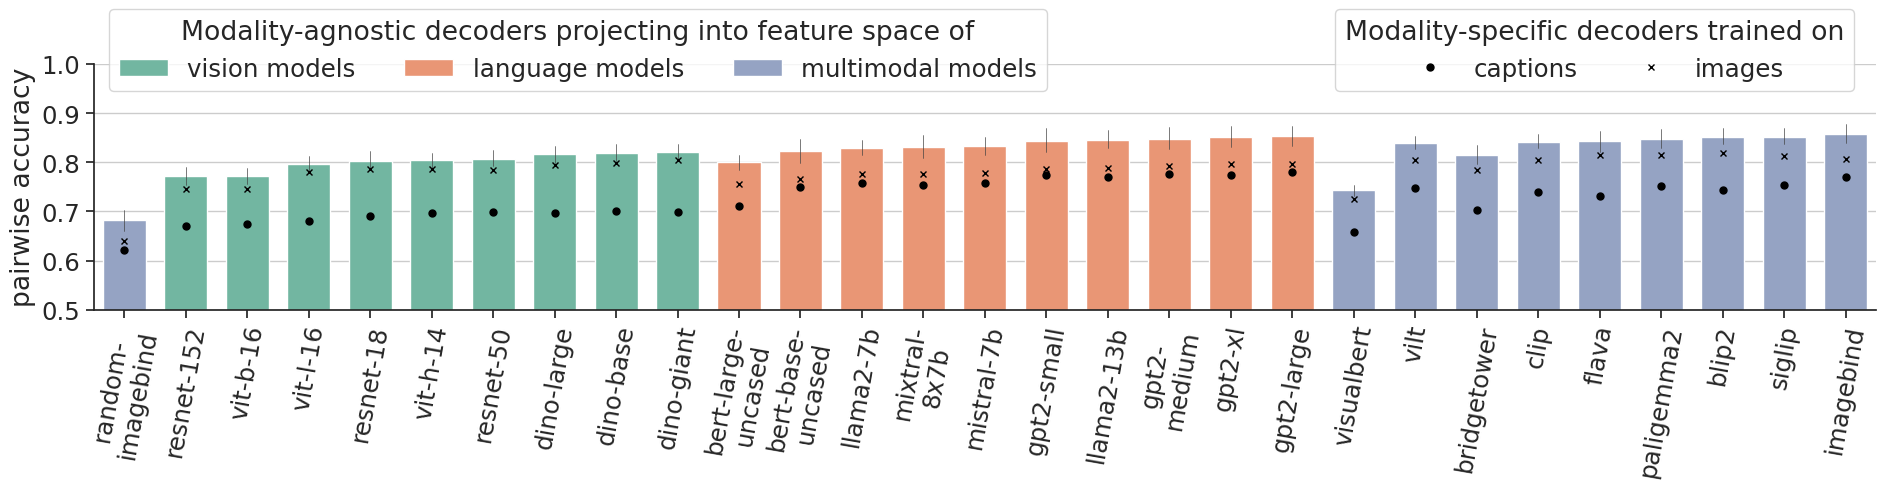

In [8]:
sns.set(font_scale=1.6)
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

# model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = [ACC_MEAN]
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,1.02), legend_2_bbox=(0.98,1.02), height=5, aspect=3.2, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


In [ ]:
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,1.02), legend_2_bbox=(0.98,1.02), height=5, aspect=3.2, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False, plot_modality_specific=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_no_mod_specific.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels(


In [ ]:
sns.set(font_scale=1.6)
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

# model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = [ACC_IMAGES, ACC_CAPTIONS]
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,1.05), legend_2_bbox=(0.99,1.05), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_split_by_modality.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


In [ ]:
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,1.05), legend_2_bbox=(0.99,1.05), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False, plot_modality_specific=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_split_by_modality_no_mod_specific.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


# Statistical tests

## Mod agnostic vs. mod specific

In [ ]:
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import statsmodels.formula.api as smf
import statsmodels.api as sm

data_default_feats_copy = data_default_feats.copy()

for metric, comparison_training_mode in zip([ACC_CAPTIONS, ACC_IMAGES], ["captions", "images"]):
    print(f"{metric} | comparison with {comparison_training_mode}")
    data_filtered = data_default_feats_copy[data_default_feats_copy.metric == metric]
    data_mod_agno = data_filtered[data_filtered.training_mode == "agnostic"]
    # data_mod_agno = data_mod_agno[data_mod_agno.model == "imagebind"]

    # print(data_mod_agno)
    # for model in data_mod_agno.model.unique():
    #     if len(data_mod_agno[data_mod_agno.model == model]) > len(SUBJECTS):
    #         print(data_mod_agno[data_mod_agno.model == model])
    # assert len(data_mod_agno) == len(SUBJECTS) * len(data_mod_agno.model.unique())

    data_mod_spec = data_filtered[data_filtered.training_mode == comparison_training_mode]

    # assert len(data_mod_spec) == len(SUBJECTS) * len(data_mod_spec.model.unique())

    print('mod agno: ', data_mod_agno.value.mean())
    print('mod spec: ', data_mod_spec.value.mean())
    print(len(data_mod_agno.value.values))
    print(len(data_mod_spec.value.values))

    display(ttest_ind(data_mod_agno.value.values, data_mod_spec.value.values))

    # display(data_mod_agno)
    data_anova = pd.concat([data_mod_agno, data_mod_spec])
    data_anova = data_anova[['model', 'subject', 'training_mode', 'value']]

    # print(data_anova)

    mod = smf.mixedlm("value ~ training_mode", data_anova, groups=data_anova["subject"]).fit()

    print("=" * 50 + "\nANOVA\n" + "=" * 50)
    # print(mod.random_effects)
    print(mod.summary())
    print('pvalues:\n', mod.pvalues)
    print('\n')
    

## Mod agnostic vs. mod specific - imagery decoding

In [ ]:
# from scipy.stats import ttest_ind
# from pymer4.models import Lmer

# data_ttest = data_default_feats.copy()

# for metric in [ACC_IMAGERY_WHOLE_TEST, ACC_IMAGERY]:
#     for comparison_training_mode in ["images", "captions"]:
#         print(f"{metric} | comparison with {comparison_training_mode}")
#         data_filtered = data_ttest[data_ttest.metric == metric]
#         data_mod_agno = data_filtered[data_filtered.training_mode == "agnostic"]
#         # data_mod_agno = data_mod_agno[data_mod_agno.model == "imagebind"]
#         assert len(data_mod_agno) == len(SUBJECTS) * len(data_mod_agno.model.unique())
    
#         data_mod_spec = data_filtered[data_filtered.training_mode == comparison_training_mode]
#         assert len(data_mod_spec) == len(SUBJECTS) * len(data_mod_spec.model.unique())
    
#         print('mod agno: ', data_mod_agno.value.mean())
#         print('mod spec: ', data_mod_spec.value.mean())
#         print(len(data_mod_agno.value.values))
#         print(ttest_ind(data_mod_agno.value.values, data_mod_spec.value.values))
    
#         # display(data_mod_agno)
#         data_glm = pd.concat([data_mod_agno, data_mod_spec])
#         # display(data_glm)
#         mod = Lmer('value ~ training_mode + (1 | subject)', data=data_glm)
#         # mod = Lmer('value ~ training_mode + (1 | model) + (1 | subject)', data=data_glm)

#         print("=" * 50 + "\nGLM\n" + "=" * 50)
#         fitted = mod.fit()
#         print(fitted)
#         print(fitted[["Estimate", "SE", "Sig"]])
#         print('\n')

In [ ]:
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import statsmodels.formula.api as smf
import statsmodels.api as sm

data_ttest = data_default_feats.copy()

for metric in [ACC_IMAGERY_WHOLE_TEST]:
    for comparison_training_mode in ["images", "captions"]:
        print(f"{metric} | comparison with {comparison_training_mode}")
        data_filtered = data_ttest[data_ttest.metric == metric]
        data_mod_agno = data_filtered[data_filtered.training_mode == "agnostic"]
        # assert len(data_mod_agno) == len(SUBJECTS) * len(data_mod_agno.model.unique()) #TODO
    
        data_mod_spec = data_filtered[data_filtered.training_mode == comparison_training_mode]

        # assert len(data_mod_spec) == len(SUBJECTS) * len(data_mod_spec.model.unique()) #TODO
    
        #TODO take model and subject into account?
        print('mod agno: ', data_mod_agno.value.mean())
        print('mod spec: ', data_mod_spec.value.mean())
        print(len(data_mod_agno.value.values))
        print(len(data_mod_spec.value.values))
        print(ttest_ind(data_mod_agno.value.values, data_mod_spec.value.values))
    
        # display(data_mod_agno)
        data_anova = pd.concat([data_mod_agno, data_mod_spec])
        data_anova = data_anova[['model', 'subject', 'training_mode', 'value']]

        # print(data_anova)

        mod = smf.mixedlm("value ~ training_mode", data_anova, groups=data_anova["subject"]).fit()

        print("=" * 50 + "\nANOVA\n" + "=" * 50)
        print(mod.summary())
        print('pvalues:\n', mod.pvalues)

        print('\n')
        

## Effect of multimodal model architecture

In [ ]:
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import statsmodels.formula.api as smf
import statsmodels.api as sm

data_ttest = data_default_feats.copy()

for metric in [ACC_MEAN]:
    print(f"{metric}")
    data_filtered = data_ttest[data_ttest.metric == metric]
    data_mod_agno = data_filtered[data_filtered.training_mode == "agnostic"]
    # data_mod_agno = data_mod_agno[data_mod_agno.model == "imagebind"]
    data_mod_agno = data_mod_agno[data_mod_agno.model != "random-imagebind"]

    assert len(data_mod_agno) == len(SUBJECTS) * len(data_mod_agno.model.unique())

    data_dual_stream = data_mod_agno[data_mod_agno.model.isin(['clip', 'imagebind', 'siglip'])].copy()
    data_dual_stream['multimodal_type'] = 'dual_stream'
    data_single_stream_early_fusion = data_mod_agno[data_mod_agno.model.isin(['visualbert', 'vilt', 'paligemma2'])].copy()
    data_single_stream_early_fusion['multimodal_type'] = 'single_stream_early_fusion'
    data_single_stream_late_fusion = data_mod_agno[data_mod_agno.model.isin(['bridgetower', 'flava', 'blip2'])].copy()
    data_single_stream_late_fusion['multimodal_type'] = 'single_stream_late_fusion'


    #TODO take model and subject into account?
    print('data_dual_stream: ', data_dual_stream.value.mean())
    print(len(data_dual_stream.value.values))
    print('data_single_stream_early_fusion: ', data_single_stream_early_fusion.value.mean())
    print(len(data_single_stream_early_fusion.value.values))
    print('data_single_stream_late_fusion: ', data_single_stream_late_fusion.value.mean())
    print(len(data_single_stream_late_fusion.value.values))

    # print(ttest_ind(data_mod_agno.value.values, data_mod_spec.value.values))

    # display(data_mod_agno)
    data_anova = pd.concat([data_dual_stream, data_single_stream_early_fusion, data_single_stream_late_fusion])
    data_anova = data_anova[['subject', 'multimodal_type', 'value']] #'model',
    print(len(data_anova))
    # print(data_anova)

    mod = smf.mixedlm("value ~ multimodal_type", data_anova, groups=data_anova["subject"]).fit()

    print("=" * 50 + "\nANOVA\n" + "=" * 50)
    # print(mod.random_effects)
    print(mod.summary())
    print('pvalues:\n', mod.pvalues)

    print('\n')
    

# Imagery decoding feat comparison

In [ ]:
sns.set(font_scale=1.6)
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

metrics_order = [ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST]
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,1.03), legend_2_bbox=(0.99,1.03), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_imagery.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


## Per-subject results

In [ ]:
FEAT_ORDER = ["vision", "lang", "matched"]
FEAT_PALETTE = sns.color_palette('Set2')[:3]

def create_result_graph_all_subjs(data, order=model_feat_order, metrics=[ACC_CAPTIONS, ACC_IMAGES], hue_variable="features", hue_order=FEAT_ORDER, ylim=None,
                        legend_title="Modality-agnostic decoders based on features from", palette=FEAT_PALETTE, dodge=False, noise_ceilings=None, plot_modality_specific=True,
                       row_variable="metric", col_variable=None):
    data_training_mode_full = data[data.training_mode == MODALITY_AGNOSTIC]


    # assert len(data_training_mode_full[(data_training_mode_full.model_feat == 'gpt2-large_lang') & (data_training_mode_full.metric == metrics[0]) & (data_training_mode_full[hue_variable] == data_training_mode_full[hue_variable].values[0])]) == 6
    for mode in TRAINING_MODES:
        data_mode = data[data.training_mode == mode]
        for x_variable_value in order:
            length = len(data_mode[(data_mode["model_feat"] == x_variable_value) & (data_mode.metric == metrics[0])])
            expected_num_datapoints = len(SUBJECTS)
            if hue_variable != "features":
                expected_num_datapoints *= len(data[hue_variable].unique())
            if (length > 0) and (length != expected_num_datapoints):
                message = f"unexpected number of datapoints: {length} (expected: {expected_num_datapoints}) (model_feat: {x_variable_value} {mode}"
                print(f"Warning: {message}")

    catplot_g, data_plotted, lgd = plot_metric_catplot(data_training_mode_full, order=model_feat_order, metrics=metrics, x_variable="model_feat", legend_title=legend_title, aspect=2, legend_bbox=(0,1.05), rotation=89, cut_labels=False,
                                                  hue_variable=hue_variable, row_variable=row_variable, col_variable=col_variable, hue_order=hue_order, palette=palette, ylim=ylim, noise_ceilings=noise_ceilings)

    if plot_modality_specific:
        for i, subj in zip(range(6), SUBJECTS):
            data_subj = data[data.subject == subj]
            data_training_mode_captions = data_subj[data_subj.training_mode == "captions"]
            data_training_mode_images = data_subj[data_subj.training_mode == "images"]
            palette = PALETTE_BLACK_ONLY
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 0], marker="o", plot_legend=False, ylim=ylim)
            g, _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 0], marker="x", plot_legend=False, ylim=ylim)
            
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 1], marker="o", plot_legend=False, ylim=ylim)
            _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 1], marker="x", plot_legend=False, ylim=ylim)
        
        handles, labels = g.get_legend_handles_labels()
        new_labels = ["captions", "images"]
        new_handles = [handles[0], handles[-1]]
        catplot_g.fig.legend(handles=new_handles, labels=new_labels, ncol=2, title="Modality-specific decoders trained on", loc='upper right')

        for i in range(6):
            catplot_g.axes[i,0].set_title(f"subject {i+1} | captions", fontsize=25)
            catplot_g.axes[i,1].set_title(f"subject {i+1} | images", fontsize=25)

            catplot_g.axes[i,0].set_ylabel('pairwise accuracy')

    return catplot_g, lgd


In [ ]:
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = calc_model_feat_order(data_to_plot, MODELS)

figure, lgd = create_result_graph_all_subjs(data_to_plot, model_feat_order, metrics=[ACC_CAPTIONS, ACC_IMAGES], hue_order=FEAT_ORDER, ylim=(0.5, 1), row_variable="subject", col_variable="metric")
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_per_subject.png"), dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0)

# Cross-modal decoding

In [ ]:
# sns.set(font_scale=1.6)
# TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
# FEAT_ORDER = ["vision models", "language models", "multimodal models"]

# data_to_plot = data_default_feats.copy()

# data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
# data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

# model_feat_order = calc_model_feat_order(data_to_plot)

# metrics_order = [ACC_CROSS_IMAGES_TO_CAPTIONS, ACC_CROSS_CAPTIONS_TO_IMAGES, ACC_CROSS_MEAN]
# figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
#                              legend_bbox=(0.06,1.05), legend_2_bbox=(0.99,1.05), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
# plt.savefig(os.path.join(RESULTS_DIR, f"cross_modal_decoding_features_comparison_pairwise_acc.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

# 

# Error analysis

In [ ]:
models = ['imagebind']

data = load_results_data(models, metrics=METRICS_ERROR_ANALYSIS)

# metric = ACC_IMAGES

all_data = data[data.model.isin(MODELS)]

all_data = all_data[all_data["mask"] == "whole_brain"]

all_data = all_data[all_data.surface == False]

data_default_feats_err_analysis = get_data_default_feats(all_data)

In [ ]:
def all_pairwise_accuracy_scores(latents, predictions, stim_types=None, metric="cosine", standardize=True):
    results = dict()
    results['comp_mats'] = dict()
    
    for modality, acc_metric_name in zip([CAPTION, IMAGE], [ACC_CAPTIONS, ACC_IMAGES]):
        preds_mod = predictions[stim_types == modality].copy()
        latents_mod = latents[stim_types == modality]
        if standardize:
            preds_mod = StandardScaler().fit_transform(preds_mod)

        dist_mat = get_distance_matrix(preds_mod, latents_mod, metric)
        diag = dist_mat.diagonal().reshape(-1, 1)
        comp_mat = diag < dist_mat

        score = dist_mat_to_pairwise_acc(dist_mat)

        results[acc_metric_name] = score
        results['comp_mats'][acc_metric_name] = (~comp_mat).astype(int)

    if standardize:
        predictions = StandardScaler().fit_transform(predictions)

    dist_mat = get_distance_matrix(predictions, latents, metric)

    mod_agnostic_accs = []
    for modality in [CAPTION, IMAGE]:
        dist_mat_within_mod = dist_mat[stim_types == modality][:, stim_types == modality]
        dist_mat_cross_modal = dist_mat[stim_types == modality][:, stim_types != modality]
        dist_mat_min = np.min((dist_mat_within_mod, dist_mat_cross_modal), axis=0)
        diag = dist_mat_min.diagonal().reshape(-1, 1)
        comp_mat = diag < dist_mat_min
        score = dist_mat_to_pairwise_acc(dist_mat_min)
        # scores = np.mean(comp_mat, axis=0)
        mod_agnostic_accs.append(score)
        results[f"pairwise_acc_mod_agnostic_{modality}s"] = score
        results['comp_mats'][f"pairwise_acc_mod_agnostic_{modality}s"] = (~comp_mat).astype(int)

    results[ACC_MODALITY_AGNOSTIC] = np.mean(mod_agnostic_accs)

    return results

metric = ACC_IMAGES #TODO which metric?

all_subj_mats = []
for subject in SUBJECTS:
    df = data_default_feats_err_analysis.copy()
    df_subj = df[(df.training_mode == MODALITY_AGNOSTIC) & (df.subject == subject)]
    predictions = df_subj[df_subj.metric == "predictions"].value.item()
    latents = df_subj[df_subj.metric == "latents"].value.item()
    stimulus_ids = df_subj[df_subj.metric == "stimulus_ids"].value.item()
    stimulus_types = df_subj[df_subj.metric == "stimulus_types"].value.item()
    
    results = all_pairwise_accuracy_scores(latents, predictions, stimulus_types)
    print(results[ACC_IMAGES])    
    mat = results['comp_mats'][metric]
    all_subj_mats.append(mat)

mat = np.sum(all_subj_mats, axis=0)
mat = mat - np.diag(np.diag(mat))

df_err = pd.DataFrame(mat, index=stimulus_ids[:70], columns=stimulus_ids[:70])

In [ ]:
# df_err = df_err.map(lambda x: 0 if x < 3 else x)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(df_err)

In [ ]:
stimuli_info = np.load(STIM_INFO_PATH, allow_pickle=True)
img_paths = {id: os.path.join(COCO_IMAGES_DIR, path) for id, path, caption in stimuli_info}
captions_dict = {id: caption for id, path, caption in stimuli_info}

from PIL import Image

def display_stimuli(coco_ids):
    imgs = [Image.open(img_paths[img_id]).convert('RGB') for img_id in coco_ids]
    min_height = np.min([np.array(im).shape[0] for im in imgs])
    stacked = np.hstack([np.array(im)[:min_height,:,:] for im in imgs])
    img = Image.fromarray(stacked)
    # print(min_height)
    captions = [captions_dict[coco_id] for coco_id in coco_ids]
    for cap in captions:
        print(cap)
    display(img)
    
# display_imgs([183210, 79642])


In [ ]:
for id1, row in df_err.iterrows():
    confusions = []
    for id2, count in row.items():
        if count > 5:
            confusions.append(id2)
    if len(confusions) > 0:
        print(f'common confusions involving id {id1}:\n')
        confusions = [id1] + confusions
        display_stimuli(confusions)
        print('\n\n')


# Alternative results presentation

In [ ]:
sns.set(font_scale=1.6)

# MODEL = 'blip2'
MODEL = 'imagebind'
data_to_plot = data_default_feats.copy()
data_to_plot = data_to_plot[data_to_plot.model == MODEL]
METRICS = [ACC_IMAGES, ACC_CAPTIONS, ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST]
data_to_plot = data_to_plot[data_to_plot.metric.isin(METRICS)]

data_to_plot.loc[(data_to_plot.training_mode == 'agnostic'), 'mode'] = 'modality-agnostic'            

for training_mode in ["images", "captions"]:
    for metric in METRICS:
        if 'imagery' in metric:
            mode = training_mode

        else:
            if training_mode == metric.split('_')[-1]:
                mode = 'within-modality'
            else: 
                mode = 'cross-modality'
    
        data_to_plot.loc[(data_to_plot.training_mode == training_mode) & (data_to_plot.metric == metric), 'mode'] = mode



display(data_to_plot.groupby(["metric", "mode"]).aggregate({"value": "mean", "subject": "count"}))
data_to_plot['decoder type'] = data_to_plot['training_mode']
data_to_plot['decoder type'] = data_to_plot['decoder type'].apply(lambda x: f'modality-specific decoder trained on {x}' if x in ['captions', 'images'] else 'modalty-agnostic decoder')


METRICS = [ACC_IMAGES, ACC_CAPTIONS]
ORDER = ['modality-agnostic', 'within-modality', 'cross-modality']
g = sns.catplot(data=data_to_plot, x="mode", order=ORDER, y="value", col="metric", col_order=METRICS, hue='decoder type', kind="bar", sharex=False, height=5, aspect=2, palette=sns.color_palette("colorblind", 3))
g.set(ylim=(0.5, 1))
g.set_axis_labels(x_var=" ", y_var="pairwise accuracy")
for ax in g.axes.flat:
    if ACC_CAPTIONS in ax.get_title():
        ax.set_title('caption decoding')
    elif ACC_IMAGES in ax.get_title():
        ax.set_title('image decoding')


METRICS = [ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST]
ORDER = ['modality-agnostic', 'images', 'captions']
g = sns.catplot(data=data_to_plot, x="mode", order=ORDER, y="value", col="metric", col_order=METRICS, hue='decoder type', kind="bar", sharex=False, height=5, aspect=2, palette=sns.color_palette("colorblind", 3))
g.set(ylim=(0.5, 1))
g.set_axis_labels(x_var=" ", y_var="pairwise accuracy")
for ax in g.axes.flat:
    if ACC_IMAGERY_WHOLE_TEST in ax.get_title():
        ax.set_title('imagery decoding (whole test set)')
    elif ACC_IMAGERY in ax.get_title():
        ax.set_title('imagery decoding')
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_split_by_modality.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


/tmp/ipykernel_2150806/3506325147.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'modality-agnostic' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_to_plot.loc[(data_to_plot.training_mode == 'agnostic'), 'mode'] = 'modality-agnostic'


value  subject
metric                              mode                                
pairwise_acc_captions               cross-modality     0.702381        6
                                    modality-agnostic  0.798137        6
                                    within-modality    0.771912        6
pairwise_acc_imagery                captions           0.750000        6
                                    images             0.888889        6
                                    modality-agnostic  0.861111        6
pairwise_acc_imagery_whole_test_set captions           0.709311        6
                                    images             0.772300        6
                                    modality-agnostic  0.781299        6
pairwise_acc_images                 cross-modality     0.768392        6
                                    modality-agnostic  0.916115        6
                                    within-modality    0.910007        6

In [ ]:
sns.set(font_scale=1.6)
# MODEL = 'blip2'
MODEL = 'imagebind'
METRICS = [ACC_IMAGES, ACC_CAPTIONS]
data_to_plot = data_default_feats.copy()
data_to_plot = data_to_plot[data_to_plot.model == MODEL]
data_to_plot = data_to_plot[data_to_plot.metric.isin(METRICS)]


ORDER = ['agnostic', 'images', 'captions']
g = sns.catplot(data=data_to_plot, x="training_mode", order=ORDER, y="value", col="metric", col_order=METRICS, kind="bar", sharex=False, height=5, aspect=2)
g.set(ylim=(0.5, 1))
g.set_axis_labels(x_var="decoder type", y_var="pairwise accuracy")
display(data_to_plot.groupby(["metric", "training_mode"]).aggregate({"value": "mean", "subject": "count"}))
for ax in g.axes.flat:
    if ACC_CAPTIONS in ax.get_title():
        ax.set_title('caption decoding')
    elif ACC_IMAGES in ax.get_title():
        ax.set_title('image decoding')
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_split_by_modality.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)
